In [31]:
import sys
import os

sys.path.append('..')

import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from mrmr import mrmr_classif

from src.machinelearning import (
    ANNClassifier,
    cross_val_sklearn,
    evaluate_ann,
    evaluate_sklearn,
    get_predictions,
    train_ann,
    train_decisiontree,
    train_skoperules,
    train_xgboost,
)
from src.ml2rules import TreeRuler, ml2tree, sample_from_df
from src.mlexplain import *
from src.utils import get_cc_mat, get_dataset, non_stratify_split, stratify_split

In [32]:
def get_value_counts(df: pd.DataFrame) -> None:
    display(
        pd.DataFrame(
        data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
        index=["percentage", "absolute"]    
    ).T
    )

# Data preprocessing

In [33]:
params = pd.read_csv('../data/dataset_experimental_KPI_cleaned.csv')
params.drop('label', axis=1, inplace=True)
print(f'Original shape: {params.shape}')

# Remove features with > 1 values
params = params.loc[:, (params <= 1).all()]
params = params.loc[:, (params >= 0).all()]

# Remove transport reactions
end_with_t = [col for col in params.columns if col.endswith('t')]
non_capital_columns = [col for col in params.columns if col[-1].islower()]
# params.drop(columns=end_with_t, inplace=True)

print(f'New shape: {params.shape}')
params.head()

Original shape: (492, 1242)
New shape: (492, 1242)


,LnGamma_AATA,LnGamma_IPPS,LnGamma_IPPSm,LnGamma_DHQTi,LnGamma_ADCS,LnGamma_ABTA,LnGamma_PGL,LnGamma_ACACT1r,LnGamma_ACOAHim,LnGamma_ACOTAim,...,sigma_km_substrate1_TRPS1,sigma_km_product1_TRPS1,sigma_km_substrate2_TRPS1,sigma_km_product2_TRPS1,sigma_km_substrate1_TRPTA,sigma_km_product1_TRPTA,sigma_km_substrate2_TRPTA,sigma_km_product2_TRPTA,sigma_km_substrate_TRPt2r,sigma_km_product_TRPt2r
0,0.1399,0.000172,9.453814e-13,0.00294,1.680451e-10,0.890265,0.131458,0.906463,3.363920e-09,0.154149,...,0.224102,0.268589,0.990159,0.159212,0.784170,0.442993,0.951108,0.976101,0.179614,0.228043
1,0.1399,0.000172,9.453814e-13,0.00294,1.680451e-10,0.890265,0.131458,0.906463,3.363920e-09,0.154149,...,0.224102,0.268589,0.990159,0.159212,0.784170,0.442993,0.951108,0.976101,0.179614,0.228043
2,0.1399,0.000172,9.453814e-13,0.00294,1.680451e-10,0.890265,0.131458,0.906463,3.363920e-09,0.154149,...,0.224102,0.268589,0.990159,0.159212,0.784170,0.442993,0.951108,0.976101,0.179614,0.228043
3,0.1399,0.000172,9.453814e-13,0.00294,1.680451e-10,0.890265,0.131458,0.906463,3.363920e-09,0.154149,...,0.590417,0.541713,0.461997,0.132996,0.521437,0.956180,0.800423,0.220943,0.723941,0.634397
4,0.1399,0.000172,9.453814e-13,0.00294,1.680451e-10,0.890265,0.131458,0.906463,3.363920e-09,0.154149,...,0.608850,0.094232,0.001948,0.696252,0.044552,0.489214,0.116618,0.386689,0.173001,0.637612


In [34]:
filename = '../data/new_KPI_old_models.csv'
kpi = pd.read_csv(filename, index_col='sample')
kpi.reset_index(drop=True, inplace=True)

# Create a new column 'label' with values 1 if new_KPI >= 3, 0 otherwise
kpi['label'] = kpi['new_KPI'].apply(lambda x: 1 if x >= 5.2 else 0)

# Add new label to params
df = params.copy()
df['label'] = kpi['label'].values

In [35]:
get_value_counts(df)

,percentage,absolute
0,0.6423,316.0
1,0.3577,176.0


# Machine Learning - Rule extraction pipeline

In [36]:
# Train-test split
train_test_split = False
if train_test_split:
    X_train, X_test, y_train, y_test = stratify_split(data=df, train_size=392, target="label")
else:
    # Use all data
    X_train = df.drop('label', axis=1)
    y_train = df['label']

    X_test = X_train.copy()
    y_test = y_train.copy()

    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Training set shape: (492, 1242)
Test set shape: (492, 1242)


In [ ]:
if os.path.exists('../models/yeast_exp/xgboost_model_full.pkl'):
    with open('../models/yeast_exp/xgboost_model_full.pkl', 'rb') as f:
        xgb_model = pickle.load(f)
else:
    xgb_model = train_xgboost(X_train, y_train, scoring='matthews_corrcoef', n_trials=100)
    with open('../models/yeast_exp/xgboost_model_full.pkl', 'wb') as f:
        pickle.dump(xgb_model, f)

In [38]:
print('Cross validation:')
cross_val_sklearn(xgb_model, X_train, y_train)

Cross validation:
Accuracy: 0.8557
Precision: 1.0
Recall: 0.5957
F1: 0.7394
ROC AUC: 0.9333
MCC: 0.6962


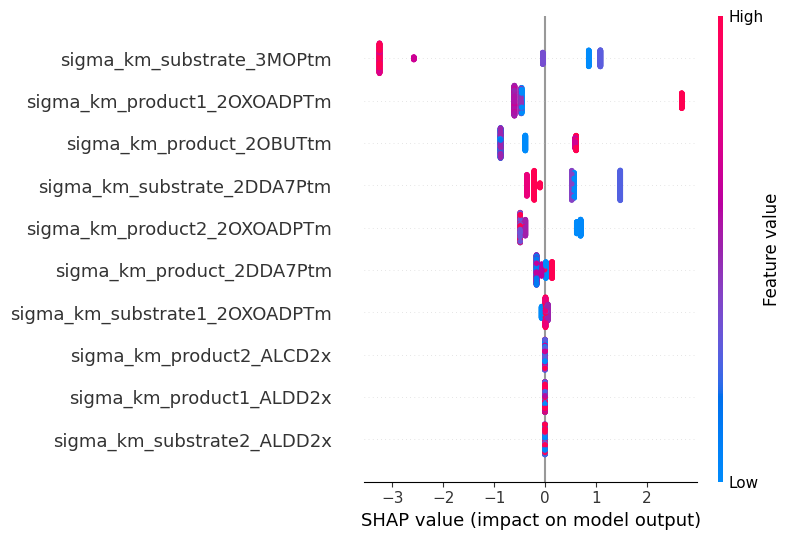

In [39]:
# Get shap values
shap_values_df = get_shap_values(xgb_model, X_train)

# Plot shap values
plt.figure(figsize=(10, 4))
shap.summary_plot(shap_values_df.values, X_train, plot_type='dot', max_display=10)
plt.show()

### Decision Tree - iSHRUNCK

In [ ]:
cart_model = train_decisiontree(X_train, y_train, scoring='matthews_corrcoef', n_trials=200)

In [41]:
# Cross-validated performance
cross_val_sklearn(cart_model, X_train, y_train)

Accuracy: 0.8171
Precision: 0.8792
Recall: 0.6522
F1: 0.7107
ROC AUC: 0.9333
MCC: 0.6278


In [42]:
ruler = TreeRuler(df=train_df, tree_clf=cart_model, target="label")
ruler.get_rules()
print(f'Number of rules: {len(ruler.rules)}')
ruler.rules

Number of rules: 4


['if (sigma_km_substrate1_SUCD2_u6m <= 0.831) and (sigma_km_substrate59_LMPD_s_0450_c_1_256 <= 0.78) then class: 1 (proba: 100.0%) | based on 209 samples',
 'if (sigma_km_substrate1_SUCD2_u6m > 0.831) then class: 0 (proba: 100.0%) | based on 105 samples',
 'if (sigma_km_substrate1_SUCD2_u6m <= 0.831) and (sigma_km_substrate59_LMPD_s_0450_c_1_256 > 0.78) and (sigma_km_substrate_PaAroZ <= 0.867) then class: 1 (proba: 58.25%) | based on 103 samples',
 'if (sigma_km_substrate1_SUCD2_u6m <= 0.831) and (sigma_km_substrate59_LMPD_s_0450_c_1_256 > 0.78) and (sigma_km_substrate_PaAroZ > 0.867) then class: 1 (proba: 62.67%) | based on 75 samples']

In [47]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(train_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['sigma_km_substrate1_SUCD2_u6m>0.831']
Number of parameter sets following the rule: 105


,percentage,absolute
1,1.0,105.0


### Skope - Rules

In [50]:
skope_rules_clf = train_skoperules(X_train, y_train, n_iter=100, scoring='f1')

In [51]:
# Print skope-rules rules
print(f'*** Number of rules {len(skope_rules_clf.rules_)}')

# Get rules
for i in skope_rules_clf.rules_[:10]:
    print(i)

*** Number of rules 5
('sigma_km_substrate1_ACS > 0.7776683568954468', (1.0, 0.6056338028169014, 2))
('sigma_km_product2_ACACT1r > 0.03748328285291791 and sigma_km_product2_CBPS > 0.6794790625572205 and sigma_km_product2_IMPD > 0.5016605630517006', (0.41379310344827586, 0.26865671641791045, 2))
('sigma_km_product2_CITtbm <= 0.5084617137908936 and sigma_km_substrate_E4Ptm <= 0.6500734984874725 and sigma_km_substrate17_LMPD_s_0450_c_1_256 > 0.3877897784113884', (0.42045454545454547, 0.2569444444444444, 2))
('sigma_km_substrate_E4Ptm <= 0.6500734984874725 and sigma_km_product_Kt2r <= 0.45622797682881355 and sigma_km_substrate2_ME2m > 0.01983820367604494', (0.4024390243902439, 0.2357142857142857, 2))
('sigma_km_product2_CITtbm > 0.5084617137908936 and sigma_km_substrate_E4Ptm <= 0.6500734984874725 and sigma_km_substrate17_LMPD_s_0450_c_1_256 > 0.3877897784113884', (0.38596491228070173, 0.1527777777777778, 2))


In [52]:
rule = skope_rules_clf.rules_[0][0]
print(rule)
sampled_df = sample_from_df(test_df, rule, skope_rules=True)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

sigma_km_substrate1_ACS > 0.7776683568954468
Number of parameter sets following the rule: 105


,percentage,absolute
1,1.0,105.0


### XGBoost

In [ ]:
xgb_preds = xgb_model.predict(X_train)
xgb2tree = ml2tree(X_train, xgb_preds, cv=10, scoring='f1', n_trials=100)

In [54]:
cross_val_sklearn(xgb2tree, X_train, y_train)

Accuracy: 0.8171
Precision: 0.8792
Recall: 0.6522
F1: 0.7107
ROC AUC: 0.9333
MCC: 0.6278


In [55]:
ruler = TreeRuler(df=train_df, tree_clf=xgb2tree, target="label")
ruler.get_rules()
ruler.rules

['if (sigma_km_substrate_Htgm <= 0.796) then class: 1 (proba: 100.0%) | based on 387 samples',
 'if (sigma_km_substrate_Htgm > 0.796) then class: 0 (proba: 100.0%) | based on 105 samples']

In [56]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['sigma_km_substrate_Htgm>0.796']
Number of parameter sets following the rule: 105


,percentage,absolute
1,1.0,105.0
